FriendFeed 的互动结构，有多碎片化、多社区化？这些社区之间是不是几乎不互动？有没有像‘桥梁’一样的用户？

## Step 1 全图基本信息（nodes / edges / components）

In [ ]:
import pickle
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt

with open("../data/network_data.pkl", "rb") as f:
    G = pickle.load(f)

type(G), G.is_directed()


(networkx.classes.graph.Graph, False)

In [2]:
# 节点数和边数
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)

# 连通分量
components = list(nx.connected_components(G))
num_components = len(components)
component_sizes = sorted([len(c) for c in components], reverse=True)

print("Number of connected components:", num_components)
print("Largest components (sizes):", component_sizes[:10])


Number of nodes: 30005
Number of edges: 258567
Number of connected components: 1234
Largest components (sizes): [26844, 122, 58, 46, 26, 25, 19, 15, 12, 11]


In [3]:
density = nx.density(G)
transitivity = nx.transitivity(G)

print("Density (full graph):", density)
print("Global clustering / transitivity (full graph):", transitivity)


Density (full graph): 0.0005744209942701413
Global clustering / transitivity (full graph): 0.13948401319815762


In [ ]:
degrees = [deg for n, deg in G.degree()]
min_deg = min(degrees)
max_deg = max(degrees)
avg_deg = sum(degrees) / len(degrees)

deg_counts = Counter(degrees).most_common(10)

print("Min degree:", min_deg)
print("Max degree:", max_deg)
print("Average degree:", avg_deg)
print("Most common degree values (degree, count):")
for d, c in deg_counts:
    print(f"  {d}: {c}")


In [ ]:
# 全图的度分布
degrees = [deg for n, deg in G.degree()]
min_deg = min(degrees)
max_deg = max(degrees)
avg_deg = sum(degrees) / len(degrees)

deg_counts = Counter(degrees).most_common(10)

print("Min degree:", min_deg)
print("Max degree:", max_deg)
print("Average degree:", avg_deg)
print("Most common degree values (degree, count):")
for d, c in deg_counts:
    print(f"  {d}: {c}")


Min degree: 1
Max degree: 2587
Average degree: 17.23492751208132
Most common degree values (degree, count):
  1: 14038
  2: 3359
  3: 1814
  4: 1163
  5: 844
  6: 633
  7: 498
  8: 432
  9: 362
  10: 317


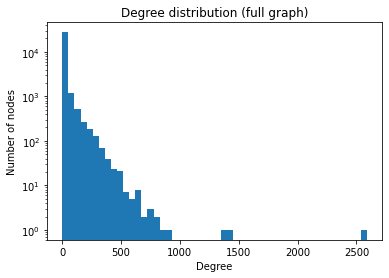

In [5]:
plt.figure(figsize=(6,4))
plt.hist(degrees, bins=50)
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.yscale("log")  # 度分布长尾，用 log y 比较清楚
plt.title("Degree distribution (full graph)")
plt.show()


In [6]:
# 提取 giant component 并计算其结构指标
# 找到最大的连通分量
giant_nodes = max(components, key=len)
G_gc = G.subgraph(giant_nodes).copy()

num_nodes_gc = G_gc.number_of_nodes()
num_edges_gc = G_gc.number_of_edges()
density_gc = nx.density(G_gc)
transitivity_gc = nx.transitivity(G_gc)

print("Giant component nodes:", num_nodes_gc)
print("Giant component edges:", num_edges_gc)
print("Density (giant component):", density_gc)
print("Global clustering / transitivity (giant):", transitivity_gc)

# giant component 占比
print("Share of nodes in giant component:", num_nodes_gc / num_nodes)


Giant component nodes: 26844
Giant component edges: 255503
Density (giant component): 0.0007091656932614446
Global clustering / transitivity (giant): 0.13920463354195806
Share of nodes in giant component: 0.8946508915180803


In [7]:
degrees_gc = [deg for n, deg in G_gc.degree()]
min_deg_gc = min(degrees_gc)
max_deg_gc = max(degrees_gc)
avg_deg_gc = sum(degrees_gc) / len(degrees_gc)

deg_counts_gc = Counter(degrees_gc).most_common(10)

print("Min degree (GC):", min_deg_gc)
print("Max degree (GC):", max_deg_gc)
print("Average degree (GC):", avg_deg_gc)
print("Most common degrees in GC (degree, count):")
for d, c in deg_counts_gc:
    print(f"  {d}: {c}")


Min degree (GC): 1
Max degree (GC): 2587
Average degree (GC): 19.036134704216956
Most common degrees in GC (degree, count):
  1: 11380
  2: 3126
  3: 1740
  4: 1127
  5: 815
  6: 621
  7: 483
  8: 421
  9: 355
  10: 310


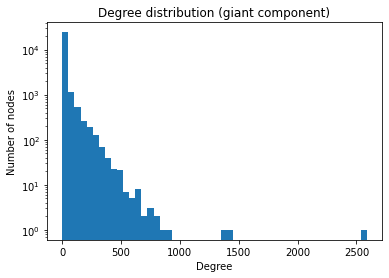

In [8]:
plt.figure(figsize=(6,4))
plt.hist(degrees_gc, bins=50)
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.yscale("log")
plt.title("Degree distribution (giant component)")
plt.show()


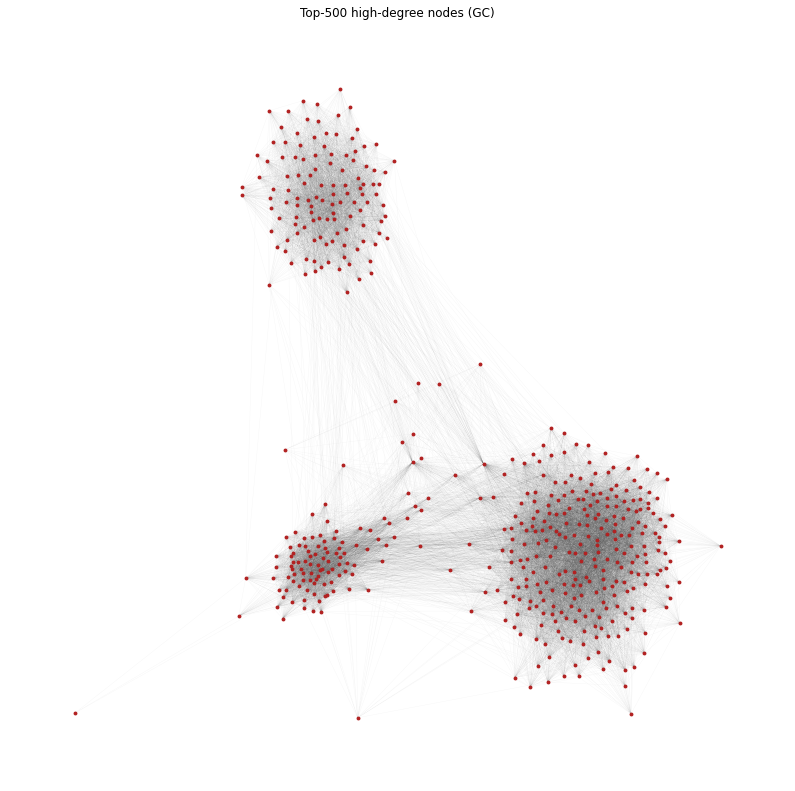

In [34]:
top_nodes = sorted(G_gc.degree, key=lambda x: x[1], reverse=True)[:500]
top_nodes = [n for n, d in top_nodes]
G_sample = G_gc.subgraph(top_nodes).copy()

plt.figure(figsize=(14, 14))
pos = nx.spring_layout(G_sample, seed=42, k=0.2, iterations=100)

nx.draw_networkx_edges(G_sample, pos, alpha=0.03, width=0.5)
nx.draw_networkx_nodes(G_sample, pos, node_size=15, node_color="firebrick", linewidths=0)

plt.title("Top-500 high-degree nodes (GC)")
plt.axis("off")
plt.show()


## Step 2 community detection

In [ ]:
import pickle
import networkx as nx
from collections import Counter

# 读取网络
with open("network_data.pkl", "rb") as f:
    G = pickle.load(f)

# 找到最大的连通分量（giant component）
components = list(nx.connected_components(G))
giant_nodes = max(components, key=len)

G_gc = G.subgraph(giant_nodes).copy()

print("GC nodes:", G_gc.number_of_nodes())
print("GC edges:", G_gc.number_of_edges())


In [24]:
from networkx.algorithms.community import louvain_communities, modularity

# 使用 Louvain 检测加权社区
# weight="weight" 使用你在边上存的评论+点赞的次数
communities_louvain = louvain_communities(G_gc, weight="weight", resolution=1.0)

print("Number of communities (Louvain):", len(communities_louvain))

# 看前几个社区的大小
sizes_louvain = sorted([len(c) for c in communities_louvain], reverse=True)
print("Largest community sizes (Louvain):", sizes_louvain[:10])


Number of communities (Louvain): 125
Largest community sizes (Louvain): [5334, 4379, 4120, 3760, 3714, 1501, 1048, 930, 487, 356]


In [25]:
Q_louvain = modularity(G_gc, communities_louvain, weight="weight")
print("Modularity Q (Louvain, weighted):", Q_louvain)


Modularity Q (Louvain, weighted): 0.6855333802577197


In [26]:
# 构造 node → community_id 映射（后面会用到）
# 把每个节点的社区 ID 存到一个 dict 里，方便后面算 intra/inter edges
node2comm_louvain = {}
for cid, comm in enumerate(communities_louvain):
    for n in comm:
        node2comm_louvain[n] = cid

# 简单检查一下
list(node2comm_louvain.items())[:5]

# 把这个映射写回图的节点属性
nx.set_node_attributes(G_gc, node2comm_louvain, name="community_louvain")

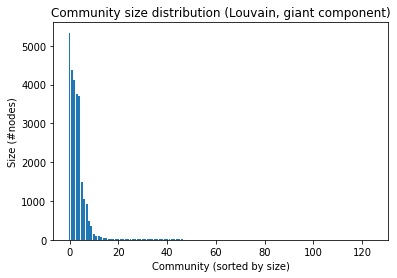

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(range(len(sizes_louvain)), sizes_louvain)
plt.xlabel("Community (sorted by size)")
plt.ylabel("Size (#nodes)")
plt.title("Community size distribution (Louvain, giant component)")
plt.show()


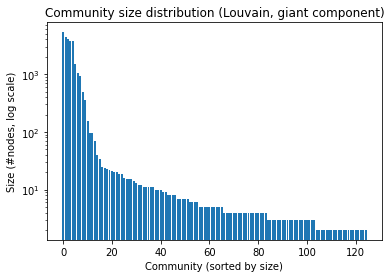

In [ ]:
# 使用对数 y 轴更清楚地展示社区大小分布
plt.figure(figsize=(6,4))
plt.bar(range(len(sizes_louvain)), sizes_louvain)
plt.yscale("log")
plt.xlabel("Community (sorted by size)")
plt.ylabel("Size (#nodes, log scale)")
plt.title("Community size distribution (Louvain, giant component)")
plt.show()


In [29]:
from networkx.algorithms.community import label_propagation_communities

communities_lp = list(label_propagation_communities(G_gc))
sizes_lp = sorted([len(c) for c in communities_lp], reverse=True)

print("Number of communities (Label Propagation):", len(communities_lp))
print("Largest community sizes (Label Propagation):", sizes_lp[:10])


Number of communities (Label Propagation): 909
Largest community sizes (Label Propagation): [10014, 3940, 3669, 1763, 1430, 857, 476, 372, 138, 132]


In [30]:
print("Top 10 sizes (Louvain):", sizes_louvain[:10])
print("Top 10 sizes (Label Propagation):", sizes_lp[:10])


Top 10 sizes (Louvain): [5334, 4379, 4120, 3760, 3714, 1501, 1048, 930, 487, 356]
Top 10 sizes (Label Propagation): [10014, 3940, 3669, 1763, 1430, 857, 476, 372, 138, 132]


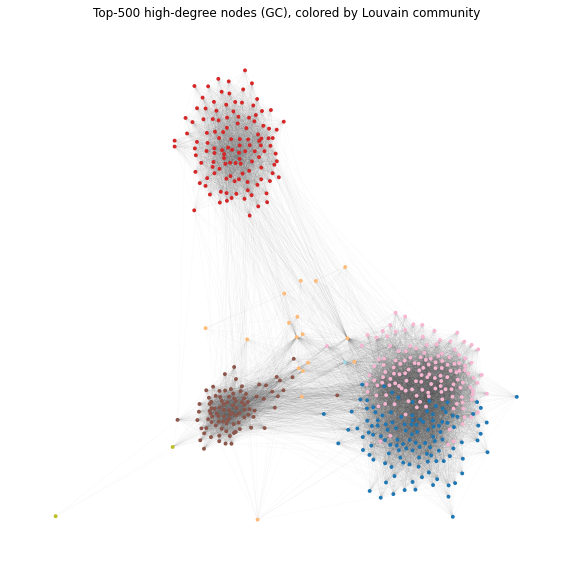

In [31]:
import matplotlib.pyplot as plt
import networkx as nx

# 1. 还是先选 GC 中度数最高的 500 个节点
top_nodes = sorted(G_gc.degree, key=lambda x: x[1], reverse=True)[:500]
top_nodes = [n for n, d in top_nodes]
G_sample = G_gc.subgraph(top_nodes).copy()

# 2. 计算布局（可以复用你之前的参数）
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_sample, seed=42, k=0.2, iterations=100)

# 3. 为每个节点取所属社区 ID
comm_labels = [G_sample.nodes[n]["community_louvain"] for n in G_sample.nodes()]

# 把社区 ID 映射到连续整数（0,1,2,...）方便 colormap 使用
unique_comms = sorted(set(comm_labels))
comm2id = {c: i for i, c in enumerate(unique_comms)}
color_values = [comm2id[c] for c in comm_labels]

# 4. 画边（淡一些）
nx.draw_networkx_edges(G_sample, pos, alpha=0.03, width=0.5)

# 5. 画点，按社区上色
nodes = nx.draw_networkx_nodes(
    G_sample,
    pos,
    node_size=15,
    node_color=color_values,   # 数值 -> colormap
    cmap=plt.cm.tab20,         # 一个离散 colormap，社区颜色比较分得开
    linewidths=0
)

plt.title("Top-500 high-degree nodes (GC), colored by Louvain community")
plt.axis("off")
plt.show()


The weighted Louvain partition of the giant component yields 125 communities with a modularity of 0.69, indicating a very pronounced community structure. The five largest communities together contain around 80% of all users, and the ten largest around 95%, while the remaining communities are much smaller. This pattern suggests that interaction on FriendFeed is organised into a few very large groups and a long tail of small communities, rather than a single undifferentiated public.

A visualisation of the subgraph induced by the 500 highest-degree users shows three dense clusters connected by relatively narrow bridges. When colouring nodes by their Louvain community, each cluster is dominated by one or two large communities, while only a small number of nodes sit on the boundaries between them. This provides a first qualitative indication of fragmented publics with limited cross-community connectivity among the most active users.

Validation: As a robustness check, we also applied label propagation. This algorithm produced fewer but larger communities, with a single giant group of about 10,000 users and several other groups of a few thousand users. Despite these quantitative differences, both methods agree on the qualitative picture: interaction in the giant component is dominated by a small number of very large communities and a long tail of much smaller ones.

## Step 3 fragmentation of publics

In [35]:
import math

# 节点总数（giant component）
N = G_gc.number_of_nodes()
print("Total nodes in GC:", N)

# 社区大小（如果你已经有 sizes_louvain，可以直接用；这里再算一遍也没问题）
print("Number of communities:", len(sizes_louvain))
print("Largest 10 community sizes:", sizes_louvain[:10])

# 最大社区的大小和占比
largest_size = sizes_louvain[0]
largest_share = largest_size / N
print("Largest community size:", largest_size)
print("Largest community share:", largest_share)

# 前 3 / 5 / 10 个社区覆盖的用户比例
top3_size = sum(sizes_louvain[:3])
top5_size = sum(sizes_louvain[:5])
top10_size = sum(sizes_louvain[:10])

print("Top-3 communities size/share:", top3_size, top3_size / N)
print("Top-5 communities size/share:", top5_size, top5_size / N)
print("Top-10 communities size/share:", top10_size, top10_size / N)

# 有效社区数 N_eff = 1 / sum(p_c^2)
p_list = [s / N for s in sizes_louvain]
N_eff = 1.0 / sum(p**2 for p in p_list)

print("Effective number of communities (N_eff):", N_eff)


Total nodes in GC: 26844
Number of communities: 125
Largest 10 community sizes: [5334, 4379, 4120, 3760, 3714, 1501, 1048, 930, 487, 356]
Largest community size: 5334
Largest community share: 0.19870362092087618
Top-3 communities size/share: 13833 0.5153106839517211
Top-5 communities size/share: 21307 0.7937341677842349
Top-10 communities size/share: 25629 0.9547384890478319
Effective number of communities (N_eff): 7.415721598257501


In [36]:
# 社区内部密度和平均 clustering
import networkx as nx
from tqdm import tqdm  # 如果没有安装，可以去掉 tqdm，改成普通 for 循环

community_stats = []

for cid, nodes in enumerate(communities_louvain):
    # 取这个社区的子图
    sub = G_gc.subgraph(nodes)  # 这是一个 view，就地算指标很方便
    size = sub.number_of_nodes()
    edges = sub.number_of_edges()
    
    # 内部边密度
    density_c = nx.density(sub)
    
    # 平均局部聚类系数
    avg_clust_c = nx.average_clustering(sub)
    
    community_stats.append(
        {
            "community_id": cid,
            "size": size,
            "edges": edges,
            "density": density_c,
            "avg_clustering": avg_clust_c,
        }
    )

len(community_stats), community_stats[0]


(125,
 {'community_id': 0,
  'size': 11,
  'edges': 8,
  'density': 0.14545454545454545,
  'avg_clustering': 0.0})

In [37]:
import pandas as pd

comm_df = pd.DataFrame(community_stats)
# 按 size 排序看看前几大社区的指标
comm_df_sorted = comm_df.sort_values("size", ascending=False)
comm_df_sorted.head(10)


,community_id,size,edges,density,avg_clustering
2,2,5334,39473,0.002775,0.161054
18,18,4379,33251,0.003469,0.233926
19,19,4120,46602,0.005492,0.202673
6,6,3760,14985,0.002120,0.116959
14,14,3714,58680,0.008510,0.218825
110,110,1501,1503,0.001335,0.002665
90,90,1048,4040,0.007364,0.194203
96,96,930,999,0.002313,0.020699
56,56,487,1666,0.014078,0.274738
51,51,356,381,0.006029,0.034532


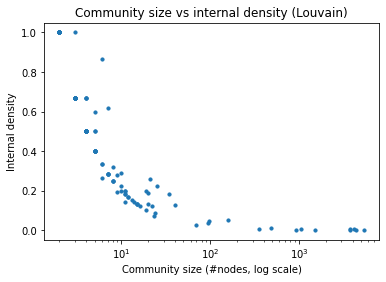

In [38]:
# 用散点图看 size vs density / clustering
# size vs density
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.scatter(comm_df["size"], comm_df["density"], s=10)
plt.xscale("log")  # 社区 size 差异很大，log x 更清楚
plt.xlabel("Community size (#nodes, log scale)")
plt.ylabel("Internal density")
plt.title("Community size vs internal density (Louvain)")
plt.show()


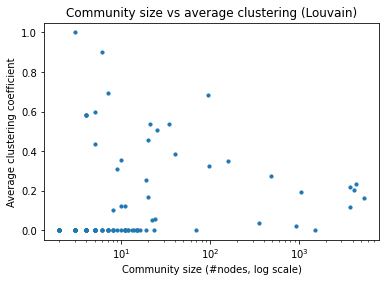

In [39]:
# size vs average clustering
plt.figure(figsize=(6,4))
plt.scatter(comm_df["size"], comm_df["avg_clustering"], s=10)
plt.xscale("log")
plt.xlabel("Community size (#nodes, log scale)")
plt.ylabel("Average clustering coefficient")
plt.title("Community size vs average clustering (Louvain)")
plt.show()


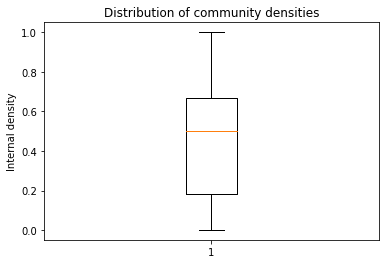

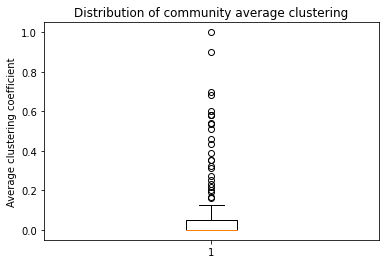

In [40]:
plt.figure(figsize=(6,4))
plt.boxplot(comm_df["density"])
plt.ylabel("Internal density")
plt.title("Distribution of community densities")
plt.show()

plt.figure(figsize=(6,4))
plt.boxplot(comm_df["avg_clustering"])
plt.ylabel("Average clustering coefficient")
plt.title("Distribution of community average clustering")
plt.show()


Based on our results, FriendFeed does not function as a single unified public sphere. In the giant component we identify 125 communities, but the effective number of communities is only about 7.4, and the ten largest groups already contain more than 95% of all users. This means that interaction is effectively concentrated in roughly seven to eight major publics plus a long tail of small groups. The platform is therefore structurally fragmented: most users participate inside a limited set of large interaction clusters rather than in one common, well-mixed space.

Internal structure also differs strongly by community size. Small communities tend to have much higher internal density and average clustering, often corresponding to near-cliques where “friends of friends are also friends”. In contrast, the largest communities (with several thousand users) are extremely sparse, with densities below 0.01 and only moderate clustering. These large communities resemble loose audiences organised around a set of central users rather than fully interconnected cliques. The largest circles are vast yet loose, functioning more like broad factions or large audience fields, potentially offering greater topic diversity and further internal segmentation.

## Step 4 Intra-community vs. Inter-community Interaction

In [41]:
# 无权：按边数算
E_intra = 0
E_inter = 0

for u, v in G_gc.edges():
    if node2comm_louvain[u] == node2comm_louvain[v]:
        E_intra += 1
    else:
        E_inter += 1

p_intra_edges = E_intra / (E_intra + E_inter)

print("Intra-community edges:", E_intra)
print("Inter-community edges:", E_inter)
print("Share of intra edges (unweighted):", p_intra_edges)


Intra-community edges: 203661
Inter-community edges: 51842
Share of intra edges (unweighted): 0.7970982728187145


In [42]:
# 加权：按总互动次数（weight）算
W_intra = 0
W_inter = 0

for u, v, d in G_gc.edges(data=True):
    w = d.get("weight", 1)
    if node2comm_louvain[u] == node2comm_louvain[v]:
        W_intra += w
    else:
        W_inter += w

p_intra_weight = W_intra / (W_intra + W_inter)

print("Intra-community weight:", W_intra)
print("Inter-community weight:", W_inter)
print("Share of intra weight (weighted):", p_intra_weight)


Intra-community weight: 817387
Inter-community weight: 115599
Share of intra weight (weighted): 0.8760978192598817


In [ ]:
'''
这里我们对每个 community c 统计：
    它内部的边数 E_in(c)（两端都是这个社区里的节点）；
    它连向外部其他社区的边数 E_out(c)；
    然后算一个 ratio_in(c) = E_in / (E_in + E_out)。
注意：跨社区边会给两个社区各记一次 E_out，这样含义是“从这个社区视角看，自己所有 incident edges 里有多少是外部边”。

这一格跑完，你就有一张表，每一行是一个社区：
    size：有多少用户
    E_in / E_out：按边数看，内部 vs 外部
    W_in / W_out：按权重（互动次数）看，内部 vs 外部
    ratio_in_edges / ratio_in_weight：两个版本的“结构 fragmentation score”。
'''
import pandas as pd

# 初始化一个 dict 存每个社区的统计
comm_edge_stats = {
    cid: {
        "community_id": cid,
        "size": len(nodes),
        "E_in": 0,
        "E_out": 0,
        "W_in": 0.0,
        "W_out": 0.0,
    }
    for cid, nodes in enumerate(communities_louvain)
}

# 遍历所有边，更新每个社区的 E_in / E_out
for u, v, d in G_gc.edges(data=True):
    cu = node2comm_louvain[u]
    cv = node2comm_louvain[v]
    w = d.get("weight", 1)

    if cu == cv:
        # 圈内边：只给这个社区加一次
        comm_edge_stats[cu]["E_in"] += 1
        comm_edge_stats[cu]["W_in"] += w
    else:
        # 跨社区边：对两个社区来说都是 "outgoing"
        comm_edge_stats[cu]["E_out"] += 1
        comm_edge_stats[cv]["E_out"] += 1

        comm_edge_stats[cu]["W_out"] += w
        comm_edge_stats[cv]["W_out"] += w

# 转成 DataFrame
comm_edge_df = pd.DataFrame.from_dict(comm_edge_stats, orient="index")

# 计算每个社区的 ratio_in（无权和加权）
comm_edge_df["ratio_in_edges"] = comm_edge_df["E_in"] / (
    comm_edge_df["E_in"] + comm_edge_df["E_out"]
)

comm_edge_df["ratio_in_weight"] = comm_edge_df["W_in"] / (
    comm_edge_df["W_in"] + comm_edge_df["W_out"]
)

# 看前 10 个最大的社区的情况
comm_edge_df.sort_values("size", ascending=False).head(10)


,community_id,size,E_in,E_out,W_in,W_out,ratio_in_edges,ratio_in_weight
2,2,5334,39473,39354,112976.0,88785.0,0.500755,0.559950
18,18,4379,33251,8320,184803.0,18529.0,0.799860,0.908873
19,19,4120,46602,40512,195890.0,91243.0,0.534954,0.682227
6,6,3760,14985,9354,41212.0,21860.0,0.615679,0.653412
14,14,3714,58680,2470,195911.0,4492.0,0.959608,0.977585
110,110,1501,1503,1459,3949.0,2444.0,0.507427,0.617707
90,90,1048,4040,470,9962.0,724.0,0.895787,0.932248
96,96,930,999,476,2065.0,672.0,0.677288,0.754476
56,56,487,1666,470,4808.0,932.0,0.779963,0.837631
51,51,356,381,188,1089.0,355.0,0.669596,0.754155


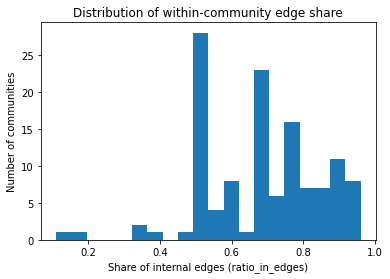

In [44]:
# 各社区的 封闭化 倾向

# 先看所有社区的 ratio_in_edges 分布，用直方图或箱线图
import matplotlib.pyplot as plt

# 只考虑至少有一些边的社区，避免除零
valid = comm_edge_df[(comm_edge_df["E_in"] + comm_edge_df["E_out"]) > 0]

plt.figure(figsize=(6,4))
plt.hist(valid["ratio_in_edges"], bins=20)
plt.xlabel("Share of internal edges (ratio_in_edges)")
plt.ylabel("Number of communities")
plt.title("Distribution of within-community edge share")
plt.show()


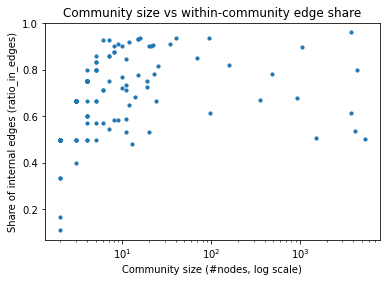

In [45]:
# 再看 ratio_in_edges vs size（看看大圈子 vs 小圈子的差别）：
plt.figure(figsize=(6,4))
plt.scatter(valid["size"], valid["ratio_in_edges"], s=10)
plt.xscale("log")
plt.xlabel("Community size (#nodes, log scale)")
plt.ylabel("Share of internal edges (ratio_in_edges)")
plt.title("Community size vs within-community edge share")
plt.show()


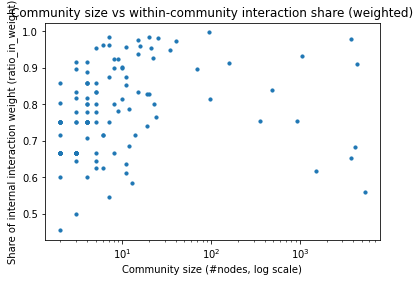

In [47]:
valid_w = comm_edge_df[(comm_edge_df["W_in"] + comm_edge_df["W_out"]) > 0]

plt.figure(figsize=(6,4))
plt.scatter(valid_w["size"], valid_w["ratio_in_weight"], s=10)
plt.xscale("log")
plt.xlabel("Community size (#nodes, log scale)")
plt.ylabel("Share of internal interaction weight (ratio_in_weight)")
plt.title("Community size vs within-community interaction share (weighted)")
plt.show()


In [48]:
# 看一下整体的 ratio_in_edges 和 ratio_in_weight 的平均值：
print("Mean ratio_in_edges:", valid["ratio_in_edges"].mean())
print("Median ratio_in_edges:", valid["ratio_in_edges"].median())

print("Mean ratio_in_weight:", valid_w["ratio_in_weight"].mean())
print("Median ratio_in_weight:", valid_w["ratio_in_weight"].median())


Mean ratio_in_edges: 0.6749650610391588
Median ratio_in_edges: 0.6666666666666666
Mean ratio_in_weight: 0.7755587027054892
Median ratio_in_weight: 0.75


That is to say, among all connections between users, approximately 80% are “within the same community,” while only 20% span across communities. The ratio of edges is roughly 4:1. In terms of interaction frequency, nearly 88% of comments and likes occur within communities, with only 12% crossing community boundaries.

This indicates that not only are structural connections predominantly intra-community, but users' actual engagement efforts are even more heavily weighted toward their own circles—the weight distribution is more extreme than the edge count.

In other words, for a typical community: Approximately 2/3 of connections are intra-community, while 1/3 extend outward; In terms of interaction volume, roughly 3/4 of interactions occur within the community, with only 1/4 happening cross-community.

Now consider examples from several major communities (from the size-sorted table):

Largest community (size 5334):
    ratio_in_edges ≈ 0.50
    ratio_in_weight ≈ 0.56
→ Structurally somewhat “open,” with roughly equal in-group/cross-group connections, though interactions slightly skew toward in-group.

Second-largest community (size 4379):
    ratio_in_edges ≈ 0.80
    ratio_in_weight ≈ 0.91
→ This community is highly inward-looking, with most connections and the vast majority of interactions occurring within the circle.

Fifth-largest community (size 3714):
    ratio_in_edges ≈ 0.96
    ratio_in_weight ≈ 0.98
→ Nearly all edges and almost all comments + likes occur within the community, forming a highly structurally closed large circle.


## Step 5 bridge users / brokers

In [ ]:
# Step 5.1 计算每个节点的 internal / external degree
import pandas as pd
from collections import defaultdict

# 初始化
internal_deg = defaultdict(int)
external_deg = defaultdict(int)

for u, v in G_gc.edges():
    cu = node2comm_louvain[u]
    cv = node2comm_louvain[v]
    if cu == cv:
        internal_deg[u] += 1
        internal_deg[v] += 1
    else:
        external_deg[u] += 1
        external_deg[v] += 1

# 把结果装进 DataFrame
nodes = list(G_gc.nodes())
data = {
    "node": nodes,
    "community_id": [node2comm_louvain[n] for n in nodes],
    "deg_total": [G_gc.degree(n) for n in nodes],
    "deg_internal": [internal_deg[n] for n in nodes],
    "deg_external": [external_deg[n] for n in nodes],
}

node_df = pd.DataFrame(data)

# external_ratio = 外部边占比
node_df["external_ratio"] = node_df["deg_external"] / (
    node_df["deg_internal"] + node_df["deg_external"]
)

node_df.head()

# external_ratio：0：只连圈内的人, 接近 1：连接几乎都指向别的社区, 中间：圈内和圈外都有


,node,community_id,deg_total,deg_internal,deg_external,external_ratio
0,001bizst,6,1,1,0,0.000000
1,nickcodipietro,6,774,561,213,0.275194
2,00yedi,2,1,1,0,0.000000
3,muratkaya,2,31,22,9,0.290323
4,02blog,14,3,3,0,0.000000


In [54]:
# Step 5.2 计算 betweenness centrality

import networkx as nx

# 近似 betweenness：随机采样 1000 个源点
betw = nx.betweenness_centrality(G_gc, k=1000, seed=42, normalized=True)

# 加入 DataFrame
node_df["betweenness"] = node_df["node"].map(betw)

node_df.head()


,node,community_id,deg_total,deg_internal,deg_external,external_ratio,betweenness,is_topk_betw
0,001bizst,6,1,1,0,0.000000,0.000000,False
1,nickcodipietro,6,774,561,213,0.275194,0.058075,True
2,00yedi,2,1,1,0,0.000000,0.000000,False
3,muratkaya,2,31,22,9,0.290323,0.000146,False
4,02blog,14,3,3,0,0.000000,0.000000,False


In [51]:
# Step 5.3 看看高 betweenness 的节点长什么样

# 按 betweenness 排序，看看前 20 名
top_betw = node_df.sort_values("betweenness", ascending=False).head(20)
top_betw


,node,community_id,deg_total,deg_internal,deg_external,external_ratio,betweenness
54,jade0307,110,2587,1485,1102,0.425976,0.142919
168,falob,6,1379,313,1066,0.773024,0.080687
186,ciaotokio,6,1417,484,933,0.658433,0.071734
1,nickcodipietro,6,774,561,213,0.275194,0.058075
244,koltregaskes,18,787,600,187,0.237611,0.030934
956,louisgray,18,649,526,123,0.189522,0.025280
589,winckel,18,513,279,234,0.456140,0.024906
444,mehmetozkan,2,804,365,439,0.546020,0.022239
92,wrzl,2,850,388,462,0.543529,0.020930
112,akiva,18,741,598,143,0.192982,0.016970


In [52]:
# Step 5.4 定义“桥梁用户”并筛出来
#   degree 至少 20（避免 degree=1、2 的噪声）
#   external_ratio > 0.4（至少 40% 的连线指向圈外）
#   或者在 betweenness 的 top-k 里面

# 先选出 "高外部比例 + 不太低 degree" 的候选
bridge_candidates = node_df[
    (node_df["deg_total"] >= 20) &
    (node_df["external_ratio"] > 0.4)
].copy()

# 再选 betweenness 前 200 的节点
topk = 200
top_betw_nodes = set(
    node_df.sort_values("betweenness", ascending=False).head(topk)["node"]
)

node_df["is_topk_betw"] = node_df["node"].isin(top_betw_nodes)

# 综合：外部比例高 或者 betweenness 在 topk
bridge_mask = (
    (node_df["deg_total"] >= 20) &
    (
        (node_df["external_ratio"] > 0.4) |
        (node_df["is_topk_betw"])
    )
)

bridge_users = node_df[bridge_mask].sort_values(
    ["betweenness", "external_ratio"], ascending=False
)

bridge_users.shape
bridge_users.head(20)

,node,community_id,deg_total,deg_internal,deg_external,external_ratio,betweenness,is_topk_betw
54,jade0307,110,2587,1485,1102,0.425976,0.142919,True
168,falob,6,1379,313,1066,0.773024,0.080687,True
186,ciaotokio,6,1417,484,933,0.658433,0.071734,True
1,nickcodipietro,6,774,561,213,0.275194,0.058075,True
244,koltregaskes,18,787,600,187,0.237611,0.030934,True
956,louisgray,18,649,526,123,0.189522,0.025280,True
589,winckel,18,513,279,234,0.456140,0.024906,True
444,mehmetozkan,2,804,365,439,0.546020,0.022239,True
92,wrzl,2,850,388,462,0.543529,0.020930,True
112,akiva,18,741,598,143,0.192982,0.016970,True


bridge user: falob is a prototypical structural broker: they have an extremely high degree, maintain a large majority of their ties to users in other communities (external_ratio ≈ 0.77), and rank among the top nodes by betweenness. This makes them a key bridge between community 6 and the rest of the network, structurally well positioned to transmit information across otherwise fragmented public

internal hub: Even within the same structural community, highly central users play different roles. Some, such as falob, are outward-oriented brokers whose ties span multiple communities, potentially mitigating structural isolation. Others, such as flo14wer, act as inward-oriented hubs that mainly amplify communication within their own group, and may therefore contribute more directly to internal echo-chamber dynamics.

## Step 6 validation: Rewired Networks (ewiring all edges so that the degree distribution is approximately preserved)

In [55]:
# Step 6.1 把 G_gc 转成 igraph，并在真实网络上算一次 Q_real 和 intra_real
import igraph as ig

# 把 NetworkX 的 G_gc 转成 igraph 图
nx_nodes = list(G_gc.nodes())
node_index = {n: i for i, n in enumerate(nx_nodes)}

ig_G_gc = ig.Graph()
ig_G_gc.add_vertices(len(nx_nodes))
ig_G_gc.vs["name"] = nx_nodes

edge_index_pairs = [(node_index[u], node_index[v]) for u, v in G_gc.edges()]
ig_G_gc.add_edges(edge_index_pairs)

ig_G_gc.summary()


'IGRAPH UN-- 26844 255503 -- \n+ attr: name (v)'

In [56]:
# 在 igraph 上跑 Louvain，并计算真实网络的 modularity 和 intra-edge ratio：
# Louvain on real graph (unweighted)
cl_real = ig_G_gc.community_multilevel()
membership_real = cl_real.membership
Q_real = cl_real.modularity

# helper: 计算 intra-edge ratio
def intra_edge_ratio_igraph(g, membership):
    intra = 0
    inter = 0
    for e in g.es:
        u = e.source
        v = e.target
        if membership[u] == membership[v]:
            intra += 1
        else:
            inter += 1
    return intra / (intra + inter)

intra_real = intra_edge_ratio_igraph(ig_G_gc, membership_real)

print("Real modularity Q:", Q_real)
print("Real intra-edge ratio:", intra_real)


Real modularity Q: 0.6126974078968659
Real intra-edge ratio: 0.9411866005487215


In [57]:
# Step 6.2 生成 degree-preserving 随机网络，并重复跑 Louvain + 计算指标

# 这里用的是 igraph 的 rewiring：做很多次 edge swap，保持每个节点度不变，但是随机重连边。
n_reps = 20   # 你可以改成 10, 20, 30，看时间情况
m_edges = ig_G_gc.ecount()

Q_random = []
intra_random = []

for r in range(n_reps):
    # 复制一份图，然后做 degree-preserving rewiring
    g_rand = ig_G_gc.copy()
    # 做 10 * M 次 rewire，一般足够随机化
    g_rand.rewire(n=10 * m_edges)

    # 在随机图上跑一样的 Louvain
    cl_rand = g_rand.community_multilevel()
    membership_rand = cl_rand.membership
    Q_rand = cl_rand.modularity
    intra_rand = intra_edge_ratio_igraph(g_rand, membership_rand)

    Q_random.append(Q_rand)
    intra_random.append(intra_rand)

print("Random Q: mean =", np.mean(Q_random), "std =", np.std(Q_random))
print("Random intra-edge ratio: mean =", np.mean(intra_random), "std =", np.std(intra_random))


Random Q: mean = 0.1477395733652873 std = 0.0006900107542654656
Random intra-edge ratio: mean = 0.2624836107599519 std = 0.009092417758749768


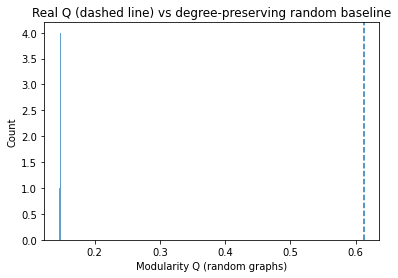

In [ ]:
# Step 6.3 画图对比真实网络 vs 随机网络
# 1）对比 modularity

plt.figure(figsize=(6,4))
plt.hist(Q_random, bins=10, alpha=0.7)
plt.axvline(Q_real, linestyle="--")
plt.xlabel("Modularity Q (random graphs)")
plt.ylabel("Count")
plt.title("Real Q (dashed line) vs degree-preserving random baseline")
plt.show()


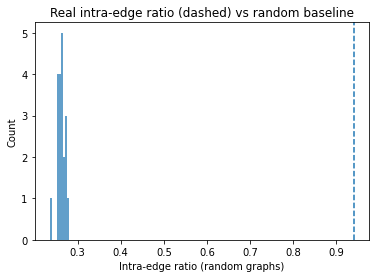

In [60]:
# 2）对比 intra-edge ratio：

plt.figure(figsize=(6,4))
plt.hist(intra_random, bins=10, alpha=0.7)
plt.axvline(intra_real, linestyle="--")
plt.xlabel("Intra-edge ratio (random graphs)")
plt.ylabel("Count")
plt.title("Real intra-edge ratio (dashed) vs random baseline")
plt.show()


We use degree-preserving random graphs as a structural baseline. Starting from the FriendFeed giant component, we repeatedly rewire edges while keeping each node’s degree fixed. For each of 20 rewired graphs, we run the same Louvain community detection and compute modularity Q and the share of within-community edges.

In the rewired networks, modularity values cluster around Q≈0.15 (mean 0.148, sd ≈ 0.001). In the empirical network, modularity is much higher, Q=0.613. The same pattern appears for within-community edges: random graphs have an intra-edge ratio of about 0.26 on average (sd ≈ 0.009), while the empirical network reaches about 0.94.

These large gaps show that strong communities and the high level of within-community interaction cannot be explained by the degree distribution alone. Given their degrees, users could in principle connect widely across the network, but in practice they cluster their ties inside specific groups. This supports our interpretation of FriendFeed as a strongly fragmented set of publics with high structural echo-chamber potential.

In [62]:
# output the results to files
cols = [
    "node", "community_id",
    "deg_total", "deg_internal", "deg_external",
    "external_ratio", "betweenness"
]

node_struct_df = node_df[cols].rename(columns={"node": "user_id"})

node_struct_df.to_pickle("../data/nodes_structural_features.pkl")


In [73]:
comm_df_sorted.to_pickle("../data/communities.pkl")       # size, density, avg_clustering 等
comm_edge_df.to_pickle("../data/communities_edge.pkl")    # E_in, E_out, ratio_in_edges 等

In [67]:
nodes_struct = pd.read_pickle("../data/nodes_structural_features.pkl")
nodes_struct.head(3)
# nodes_struct.info()

,user_id,community_id,deg_total,deg_internal,deg_external,external_ratio,betweenness
0,001bizst,6,1,1,0,0.000000,0.000000
1,nickcodipietro,6,774,561,213,0.275194,0.058075
2,00yedi,2,1,1,0,0.000000,0.000000


In [71]:
comm = pd.read_pickle("../data/communities.pkl")
comm.head(3)
# comm.columns.info()

,community_id,size,edges,density,avg_clustering
2,2,5334,39473,0.002775,0.161054
18,18,4379,33251,0.003469,0.233926
19,19,4120,46602,0.005492,0.202673


In [74]:
comm_edges = pd.read_pickle("../data/communities_edge.pkl")
comm_edges.head(3)
# comm_edges.columns.info()

,community_id,size,E_in,E_out,W_in,W_out,ratio_in_edges,ratio_in_weight
0,0,11,8,7,14.0,8.0,0.533333,0.636364
1,1,6,4,3,5.0,3.0,0.571429,0.625000
2,2,5334,39473,39354,112976.0,88785.0,0.500755,0.559950
